In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt

# Pytorch 
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader

# Other custom files
sys.path.append('../')
import modules.Dataset as data_handler
import modules.transforms as transforms
import modules.model as model

# Dataset

In [3]:
CROP_DIM = 256
data_root = '../data/processed'

## Transforms

In [4]:
data_transforms = torchvision.transforms.Compose([transforms.RandomCropper(CROP_DIM),
                               transforms.LRFlipper(),
                               transforms.Rotator(),
                               transforms.ToTensor(),
                               transforms.Normalizer()
                                ])

## Load data

In [5]:
dataset = data_handler.BeeDataset(data_root, data_transforms)

Loading paths...
Num paths loaded: 10


In [6]:
dataloader = DataLoader(dataset, batch_size=4)

In [7]:
for x, y in dataloader:
    break

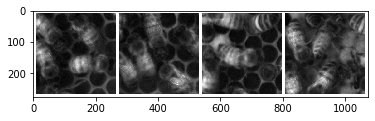

In [8]:
img = make_grid(x, normalize=True, pad_value=1, padding=10).permute(1,2,0)
plt.imshow(img);

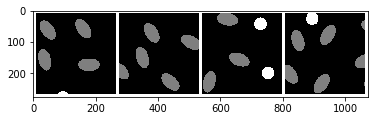

In [9]:
mask = make_grid(y.float(), normalize=True, pad_value=1, padding=10).permute(1,2,0)
plt.imshow(mask);

# Load class weights

In [10]:
class_weights = np.load('../data/class_weights.npy')
class_weights = torch.tensor(class_weights).float()

In [11]:
class_weights

tensor([0.1228, 0.4386, 0.4386])

# Model

In [12]:
num_classes = 3

In [13]:
net = model.UNet(num_classes, upsampling='subpixel')
net.eval();

In [14]:
out = net(x)

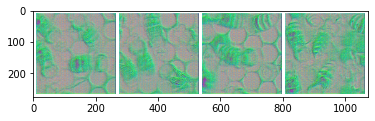

In [15]:
mask = make_grid(out.float(), normalize=True, pad_value=1, padding=10).permute(1,2,0)
plt.imshow(mask.detach().numpy());

In [16]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

In [17]:
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Train loop

In [18]:
num_epochs = 10

In [19]:
y.min(), y.max()

(tensor(0, dtype=torch.uint8), tensor(2, dtype=torch.uint8))

In [20]:
outputs = []
losses = []

In [21]:
net.train()
for epoch_i in range(num_epochs):
    for x, y in dataloader:
        y = y.long().squeeze(dim=1)
        y_pred = net(x)
        loss = criterion(y_pred, y)
        losses.append(loss.item())
        outputs.append(y_pred)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        sys.stdout.write(f'\rEpoch {epoch_i+1}/{num_epochs} -- Loss: {loss}')
        sys.stdout.flush()
    

Epoch 10/10 -- Loss: 0.8871124982833862

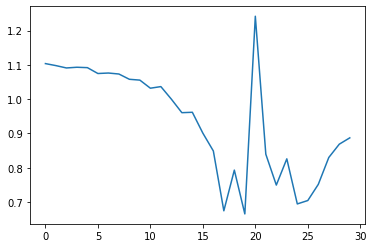

In [22]:
plt.plot(losses)

In [23]:
out.shape

torch.Size([4, 3, 256, 256])

In [24]:
softmax = nn.Softmax(dim=1)

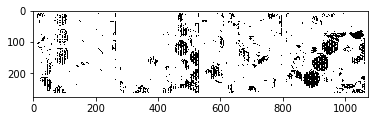

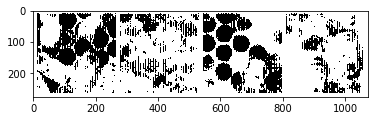

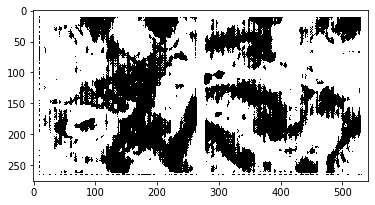

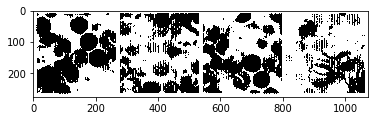

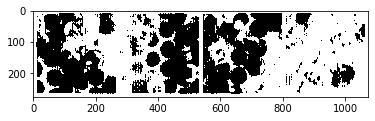

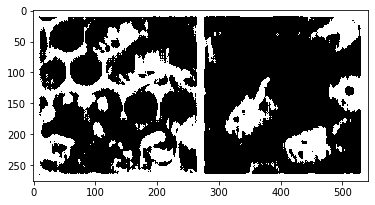

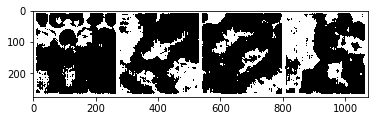

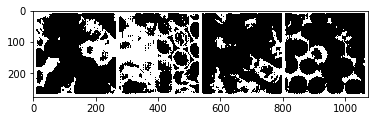

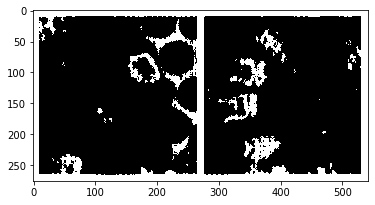

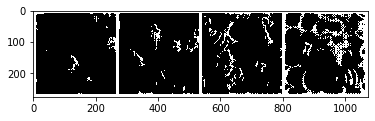

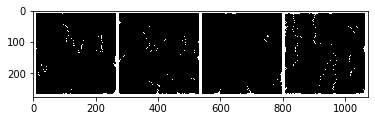

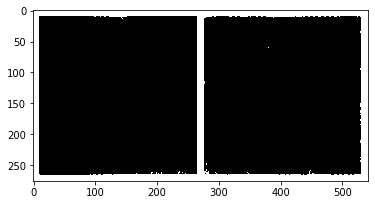

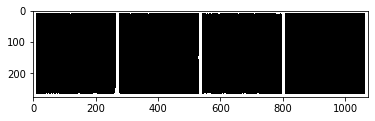

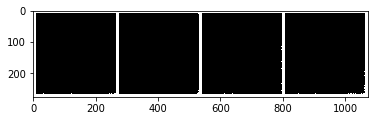

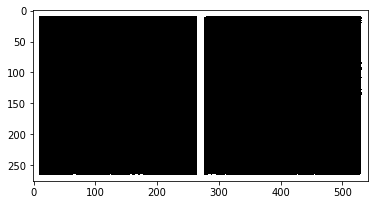

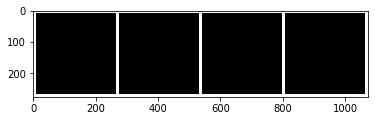

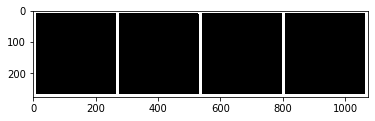

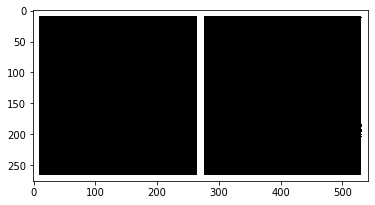

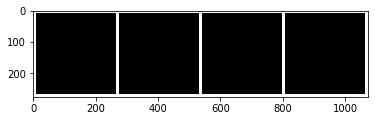

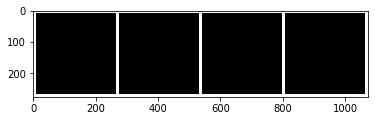

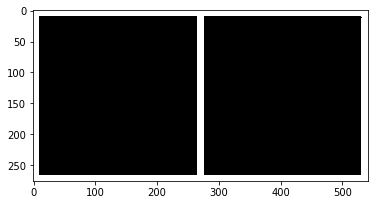

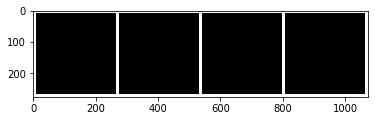

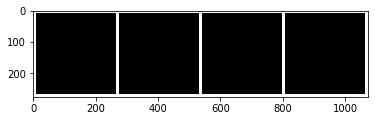

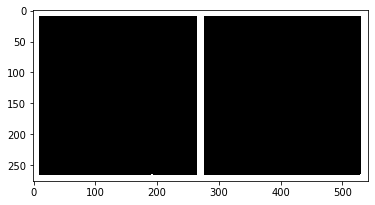

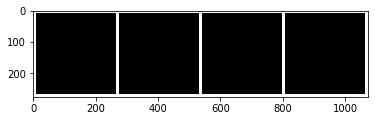

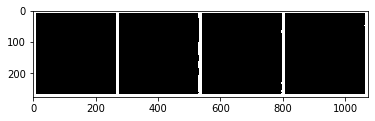

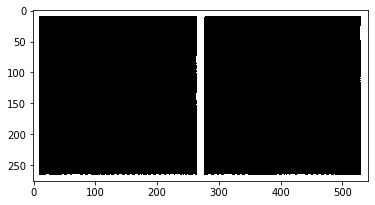

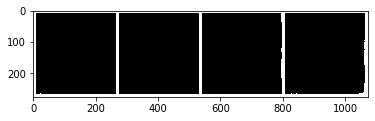

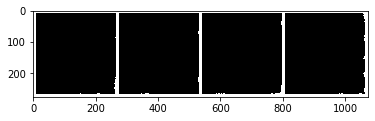

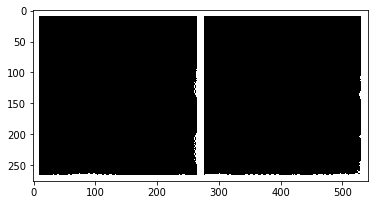

<Figure size 432x288 with 0 Axes>

In [25]:
target_labels = 1
for logits in outputs:
    pred = softmax(logits)
    
    labels = torch.argmax(pred, dim=1)
    
    # See class 1
    out = torch.zeros_like(labels).byte()
    out[labels == target_labels] = 255    
    mask = make_grid(out.unsqueeze(dim=1), pad_value=255, padding=10).permute(1,2,0)
    plt.imshow(mask.detach().numpy())
    plt.show()
    plt.clf()